## Introduction

The goal of this pyhton code is to determine which chassis suspension features have the most influence on boom height stability of self-propelled sprayers.  These features are inherent of vehicle dynamics characteristics related to the chassis of the machine, such as roll rate, vertical acceleration, etc.  This analysis will be conducted with a supervised machine learning algorithm called "Random Forest" in order to extract the most important chassis features.

In [267]:
#imports most of the necessary python packages for this data analysis
import numpy as np
import sklearn as sk
import sklearn.datasets as skd
import sklearn.ensemble as ske
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

## Data Wrangling

The data needs to be organized into a panda's dataframe for visual clarity and easy utilization.  Each index represents an entire field pass of the same machine configuration.  The following key performance indicators are based on average values and are included in this initial overview dataframe:
- Chassis roll
- Chassis roll rate
- Chassis pitch
- Chassis pitch rate
- Chassis vertical acceleration
- Chassis longitudinal acceleration
- Chassis lateral acceleration


- L2 ultrasonic elevation
- R2 ultrasonic elevation
- Average L2 & R2 ultrasonic elevation

In [517]:
#reads the data into a pandas dataframe and displays the first 10 rows
chassis_data_df = pd.read_csv('Chassis_Features_Mean_1.csv')
chassis_data_df.head(10)

,Chassis_Roll_mean,Chassis_Roll_Rate_mean,Chassis_Pitch_mean,Chassis_Pitch_Rate_mean,Chassis_Vert_Accel_mean,Chassis_Long_Accel_mean,Chassis_Lat_Accel_mean,Boom_L2_std,Boom_R2_std,Boom_L2_R2_Average_std
0,2.284831,0.196373,1.515955,-0.480477,9.813797,0.153772,0.466084,168.179845,165.326849,166.753347
1,-2.357010,0.252221,-0.655178,-0.576797,9.810353,0.107525,-0.366866,173.627026,215.386613,194.506819
2,0.621063,0.282433,1.346402,-0.502552,9.824900,0.190726,0.249052,188.293229,234.054875,211.174052
3,2.492119,0.227887,0.007240,-0.539620,9.807254,0.074085,0.420933,176.257845,208.258146,192.257995
4,-2.860568,0.237381,1.472113,-0.559221,9.807675,0.170151,-0.312717,168.987986,216.126756,192.557371
5,3.440322,0.260563,-0.288552,-0.552804,9.805874,0.064734,0.518340,217.550777,195.837967,206.694372
6,1.689145,0.156441,1.430515,-0.478650,9.819644,0.132030,0.267781,200.433252,196.479785,198.456519
7,-1.927387,0.226862,0.619088,-0.502623,9.818433,0.204058,-0.171645,190.650008,210.137701,200.393854
8,2.189631,0.290175,0.894358,-0.456564,9.814669,0.112426,0.418233,293.422035,288.378679,290.900357
9,-0.462547,0.384812,0.150088,-0.590048,9.803622,0.117205,-0.034005,284.657096,278.674454,281.665775


## Initial Data Analysis

This section of code serves as an initial investigation to questions like: what does the data look like? are there any null values present in the dataframe? what is the spread of each data signal?  what is the correlation behind the various features?

In [518]:
chassis_data_df.shape

(42, 10)

In [519]:
rows = chassis_data_df.shape[0]

"The overall dataframe shape implies that %i field passes are included in this analysis." % rows

'The overall dataframe shape implies that 42 field passes are included in this analysis.'

In [520]:
#validating that no null values are present in the data
pd.isnull(chassis_data_df).sum()

Chassis_Roll_mean          0
Chassis_Roll_Rate_mean     0
Chassis_Pitch_mean         0
Chassis_Pitch_Rate_mean    0
Chassis_Vert_Accel_mean    0
Chassis_Long_Accel_mean    0
Chassis_Lat_Accel_mean     0
Boom_L2_std                0
Boom_R2_std                0
Boom_L2_R2_Average_std     0
dtype: int64

In [521]:
#quick investigation behind the spread of the data for each column in the overall dataframe
chassis_data_df.describe()

,Chassis_Roll_mean,Chassis_Roll_Rate_mean,Chassis_Pitch_mean,Chassis_Pitch_Rate_mean,Chassis_Vert_Accel_mean,Chassis_Long_Accel_mean,Chassis_Lat_Accel_mean,Boom_L2_std,Boom_R2_std,Boom_L2_R2_Average_std
count,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000
mean,0.442188,0.257400,0.743459,-0.523652,9.810800,0.133781,0.126774,208.862895,214.437658,211.650276
std,2.025554,0.050148,1.084782,0.044463,0.006973,0.100892,0.318434,47.877687,45.951347,43.015771
min,-2.860568,0.156441,-1.147106,-0.599037,9.794721,-0.050209,-0.380614,115.204922,135.162572,125.183747
25%,-1.443751,0.224307,-0.073512,-0.558001,9.807360,0.074134,-0.149239,177.197149,184.992987,188.520148
50%,0.724170,0.258274,0.800210,-0.529100,9.810317,0.135314,0.235028,199.423455,209.197924,199.939304
75%,2.170897,0.281632,1.504994,-0.479812,9.814451,0.196928,0.412479,226.177425,232.258735,229.035091
max,3.440322,0.384812,2.832437,-0.443456,9.824900,0.337143,0.550201,379.759626,370.262662,332.416058


In [522]:
#separating the chassis feature data from the overall dataframe
chassis_features_df = chassis_data_df.iloc[:,0:7]
chassis_features_df.head()

,Chassis_Roll_mean,Chassis_Roll_Rate_mean,Chassis_Pitch_mean,Chassis_Pitch_Rate_mean,Chassis_Vert_Accel_mean,Chassis_Long_Accel_mean,Chassis_Lat_Accel_mean
0,2.284831,0.196373,1.515955,-0.480477,9.813797,0.153772,0.466084
1,-2.357010,0.252221,-0.655178,-0.576797,9.810353,0.107525,-0.366866
2,0.621063,0.282433,1.346402,-0.502552,9.824900,0.190726,0.249052
3,2.492119,0.227887,0.007240,-0.539620,9.807254,0.074085,0.420933
4,-2.860568,0.237381,1.472113,-0.559221,9.807675,0.170151,-0.312717


In [523]:
#separating the prediction data (L2/R2 average standard deviation) from the overall dataframe
boom_std_df = chassis_data_df.iloc[:,9]
boom_std_df.head()

0    166.753347
1    194.506819
2    211.174052
3    192.257995
4    192.557371
Name: Boom_L2_R2_Average_std, dtype: float64

In [524]:
#checking the correlation between the various features
feature_corr = chassis_features_df.corr(method = "pearson")
feature_corr

,Chassis_Roll_mean,Chassis_Roll_Rate_mean,Chassis_Pitch_mean,Chassis_Pitch_Rate_mean,Chassis_Vert_Accel_mean,Chassis_Long_Accel_mean,Chassis_Lat_Accel_mean
Chassis_Roll_mean,1.000000,-0.140797,-0.297325,0.098874,-0.087890,-0.506123,0.988183
Chassis_Roll_Rate_mean,-0.140797,1.000000,0.015552,-0.396220,-0.460490,0.011590,-0.147562
Chassis_Pitch_mean,-0.297325,0.015552,1.000000,0.519107,0.136100,0.898693,-0.268999
Chassis_Pitch_Rate_mean,0.098874,-0.396220,0.519107,1.000000,0.517093,0.506307,0.102526
Chassis_Vert_Accel_mean,-0.087890,-0.460490,0.136100,0.517093,1.000000,0.215740,-0.080646
Chassis_Long_Accel_mean,-0.506123,0.011590,0.898693,0.506307,0.215740,1.000000,-0.481118
Chassis_Lat_Accel_mean,0.988183,-0.147562,-0.268999,0.102526,-0.080646,-0.481118,1.000000


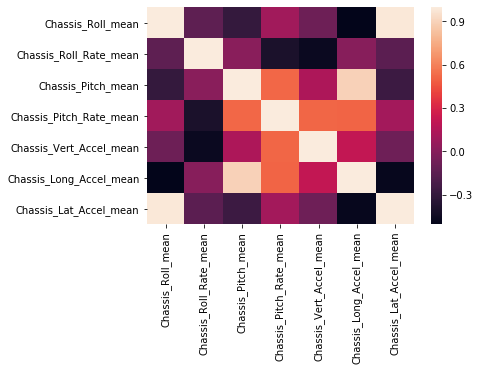

In [525]:
#produces a correlation heatmap for visual effect using the seaborn package within python
import seaborn as sns
sns.heatmap(feature_corr)

As indicated by the correlation heatmap, the most highly correlated features are chassis lateral acceleration and chassis roll.

## Random Forest Machine Learning Algorithm

In [526]:
from sklearn.model_selection import train_test_split

In [527]:
#training the machine learning model with a specified test size and random state
X_train, X_test, Y_train, Y_test = train_test_split(chassis_features_df, boom_std_df, test_size = 0.25, random_state = 0)

In [528]:
print(X_train.shape, Y_train.shape)

(31, 7) (31,)


In [529]:
reg = ske.RandomForestRegressor(n_estimators = 1000, random_state = 0)
reg.fit(X_train, Y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=1000,
                      n_jobs=None, oob_score=False, random_state=0, verbose=0,
                      warm_start=False)

In [530]:
Y_train = np.ravel(Y_train)
reg.fit(X_train, Y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=1000,
                      n_jobs=None, oob_score=False, random_state=0, verbose=0,
                      warm_start=False)

In [531]:
Y_pred = reg.predict(X_test)

In [532]:
from sklearn.metrics import explained_variance_score, max_error, mean_absolute_error, mean_squared_error, r2_score

In [533]:
#explained variance regression score function (best possible score is 1.0, lower values are worse)
explained_variance_score(Y_test, Y_pred)

0.4702770063002252

In [534]:
#max_error calculates the maximum residual error
max_error(Y_test, Y_pred)

98.97950204560036

In [535]:
#evaluates the importance of features on an artificial classification task
reg.feature_importances_

array([0.04342778, 0.49609671, 0.08157301, 0.12375994, 0.11016348,
       0.0819419 , 0.06303719])

In [536]:
#sorts the index of the features
fet_ind = np.argsort(reg.feature_importances_)[::-1]
fet_ind

array([1, 3, 4, 5, 2, 6, 0], dtype=int64)

In [537]:
#sorts the actual values of the features in ascending order
fet_imp = reg.feature_importances_[np.argsort(reg.feature_importances_)][::-1]
fet_imp

array([0.49609671, 0.12375994, 0.11016348, 0.0819419 , 0.08157301,
       0.06303719, 0.04342778])

In [538]:
#labels the index of the features by their columns names
chassis_features_df.columns[fet_ind]

Index(['Chassis_Roll_Rate_mean', 'Chassis_Pitch_Rate_mean',
       'Chassis_Vert_Accel_mean', 'Chassis_Long_Accel_mean',
       'Chassis_Pitch_mean', 'Chassis_Lat_Accel_mean', 'Chassis_Roll_mean'],
      dtype='object')

Text(0.5, 1.0, 'Chassis Feature Importance')

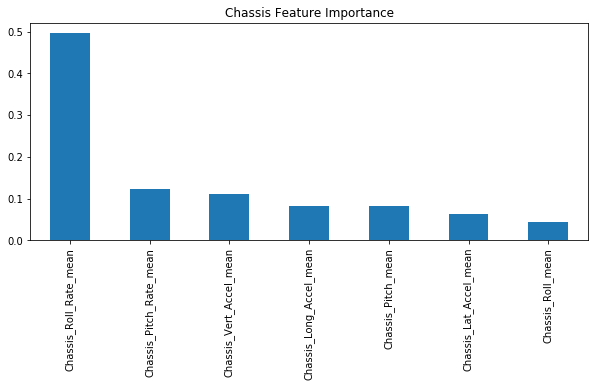

In [539]:
#creates a bar plot of feature importance
fig, ax = plt.subplots(1, 1, figsize = (10,4))
labels = chassis_features_df.columns[fet_ind]
pd.Series(fet_imp, index = labels).plot('bar', ax=ax)
ax.set_title('Chassis Feature Importance')

In [542]:
from sklearn import tree
reg.estimators_[0]

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features='auto',
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=209652396, splitter='best')

In [547]:
#generates an output microsoft word document of code that visualizes a random forest decision tree
#this code can be copied over to http://www.webgraphviz.com/
tree.export_graphviz(reg.estimators_[6], 'tree.dot', feature_names = chassis_features_df.columns, rounded=True, precision=1)